# Autoencoder + MLP for CO₂ Emission Prediction

In [10]:

# STEP 0: Install and Import Libraries
!pip install openpyxl shap eli5 scikeras --quiet

import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## STEP 1: Upload and Load Dataset

In [2]:

uploaded = files.upload()
data = pd.read_excel(io.BytesIO(uploaded['Agrofood_co2_emission_Final.xlsx']),
                     sheet_name='Agrofood_co2_emission_imputedKN')
data.head()


Saving Agrofood_co2_emission_Final.xlsx to Agrofood_co2_emission_Final.xlsx


,Region,Area,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,...,Manure Management,Fires in organic soils,Fires in humid tropical forests,On-farm energy use,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature ¬∞C
0,Central America & Caribbean,Anguilla,1990,13.526226,23.528194,9.604846,3183.472299,190.443060,11.481085,2.2211,...,17.086313,0.0,22.234258,1.3833,0.0,8334.0,4120.0,4196.0,12947.412394,0.392583
1,Central America & Caribbean,Anguilla,1991,3.384700,6.576345,5.016754,3011.420430,174.014819,11.481085,2.2562,...,18.923397,0.0,4.343317,1.4630,0.0,8666.0,4279.0,4338.0,12775.517025,0.395417
2,Central America & Caribbean,Anguilla,1992,8.929309,13.505295,6.859729,3183.472299,183.264177,11.481085,2.3594,...,18.657334,0.0,11.039042,1.3625,0.0,8981.0,4412.0,4474.0,12948.448494,0.421500
3,Central America & Caribbean,Anguilla,1993,6.543537,10.892314,5.211274,5305.567622,182.162986,11.481085,2.4624,...,42.552016,0.0,8.325684,1.2062,0.0,9266.0,4523.0,4598.0,15072.074517,0.570167
4,Central America & Caribbean,Anguilla,1994,3.458118,13.251612,1.620085,5305.567622,175.146021,11.481085,2.5654,...,16.054040,0.0,9.572550,1.1567,0.0,9537.0,4636.0,4720.0,15072.228817,0.572500


## STEP 2: Data Cleaning and Filtering

In [3]:

data_cleaned = data.drop(columns=['Region', 'Area', 'Year'])
cor_matrix = data_cleaned.corr()
low_corr = cor_matrix['total_emission'].abs()[cor_matrix['total_emission'].abs() < 0.2].index.tolist()
if 'total_emission' in low_corr: low_corr.remove('total_emission')
data_cleaned = data_cleaned.drop(columns=low_corr)


## STEP 3: Split and Scale Data

In [4]:

X = data_cleaned.drop(columns=['total_emission'])
y = data_cleaned['total_emission']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## STEP 4: Build and Train Autoencoder

In [5]:

input_dim = X_train_scaled.shape[1]

# Define Autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X_train_scaled, X_train_scaled, validation_split=0.2,
                epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

# Encoder for feature compression
encoder = Model(inputs=input_layer, outputs=encoded)
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)


Epoch 1/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6555 - val_loss: 0.2973
Epoch 2/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1610 - val_loss: 0.1511
Epoch 3/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0934 - val_loss: 0.0964
Epoch 4/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0625 - val_loss: 0.0894
Epoch 5/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0449 - val_loss: 0.0778
Epoch 6/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0401 - val_loss: 0.0665
Epoch 7/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.0644
Epoch 8/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0352 - val_loss: 0.0554
Epoch 9/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0295 - val_loss: 0.0537
Epoch 10/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 - val_loss: 0.0621
Epoch 11/100
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0322 - val_loss: 0.0421
Epoch 12/100
122/122 ━━━━━━━━━━━━━━━━━━━━

 STEP 4.1: Visualize Encoded Latent Space with t-SNE

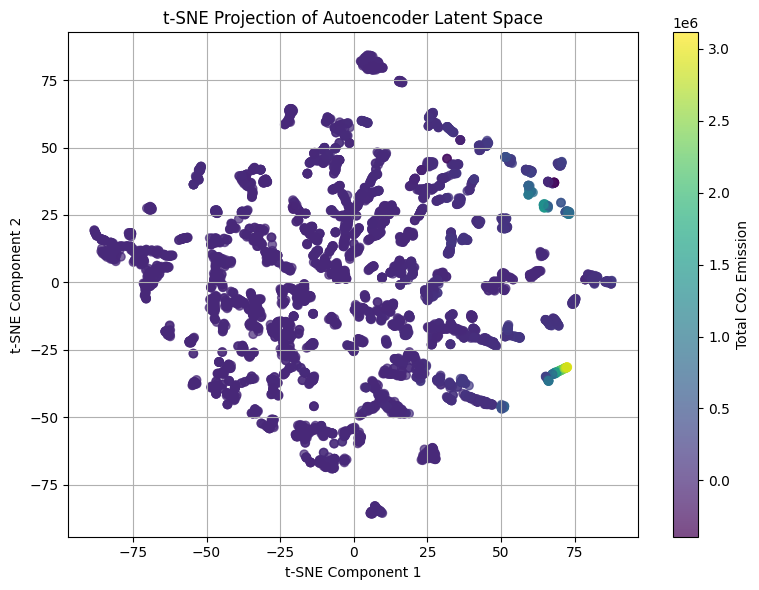

In [11]:
# Reduce the 16-dimensional encoded output to 2D
# 16-dimensional encoded features to 2D using t-SNE or UMAP to visually explore how well the autoencoder separated the data.
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_train_tsne = tsne.fit_transform(X_train_encoded)

# Plot the 2D latent space with coloring based on target emission
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Total CO₂ Emission')
plt.title("t-SNE Projection of Autoencoder Latent Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## STEP 5: MLP Regressor on Encoded Features

In [6]:

mlp = Sequential([
    Input(shape=(X_train_encoded.shape[1],)),
    Dense(128, activation='relu'), Dropout(0.3),
    Dense(64, activation='relu'), Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

mlp.compile(optimizer='adam', loss='mse')
stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = mlp.fit(X_train_encoded, y_train, validation_split=0.2,
                  epochs=200, batch_size=32, callbacks=[stopper, reduce_lr], verbose=1)
print("MLP Model Summary:")
mlp.summary()


Epoch 1/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 48745103360.0000 - val_loss: 54058319872.0000 - learning_rate: 0.0010
Epoch 2/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52387540992.0000 - val_loss: 50382041088.0000 - learning_rate: 0.0010
Epoch 3/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52164227072.0000 - val_loss: 34435887104.0000 - learning_rate: 0.0010
Epoch 4/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36262592512.0000 - val_loss: 18235955200.0000 - learning_rate: 0.0010
Epoch 5/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18208829440.0000 - val_loss: 12183922688.0000 - learning_rate: 0.0010
Epoch 6/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12919876608.0000 - val_loss: 10358137856.0000 - learning_rate: 0.0010
Epoch 7/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12785139712.0000 - val_loss: 9100370944.0000 - learning_rate: 0.0010
Epoch 8/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11877588992.0000 - val_

In [15]:
# Step 5.1: Complexity Indicator – Parameter to Sample Ratio
num_params = mlp.count_params()
num_samples = X_train_encoded.shape[0]

param_ratio = num_params / num_samples
print(f"\nTotal Trainable Parameters: {num_params}")
print(f"Number of Training Samples: {num_samples}")
print(f"Parameter-to-Sample Ratio: {param_ratio:.2f}")



Total Trainable Parameters: 12545
Number of Training Samples: 4875
Parameter-to-Sample Ratio: 2.57
MLP Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,637 (147.02 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,092 (98.02 KB)

In [14]:
# OverFitting check
from sklearn.metrics import r2_score

# Predict on training data using the MLP
y_train_pred = mlp.predict(X_train_encoded).flatten()

# Compute R² scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"R² Gap (Train - Test): {train_r2 - test_r2:.4f}")


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train R²: 0.9828
Test R²: 0.9745
R² Gap (Train - Test): 0.0083


## STEP 6: Visualizations and Evaluation

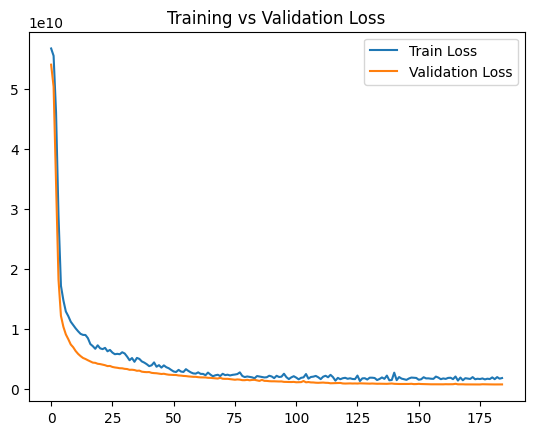

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 1328688558.35
RMSE: 36451.18
MAE: 14504.70
R²: 0.9745


In [7]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

y_pred = mlp.predict(X_test_encoded).flatten()
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.4f}")


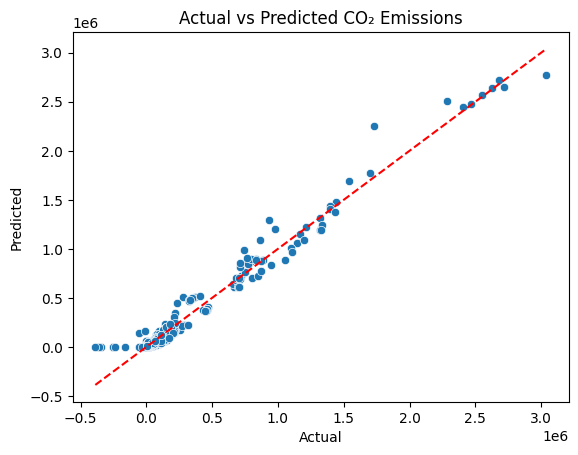

In [8]:

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.scatterplot(data=results, x='Actual', y='Predicted')
plt.plot([results.min().min(), results.max().max()], [results.min().min(), results.max().max()], 'r--')
plt.title("Actual vs Predicted CO₂ Emissions")
plt.show()


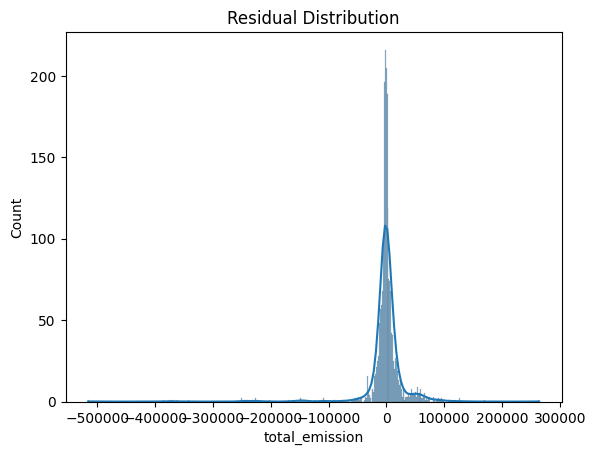

In [9]:

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()
